In [35]:
import importlib
import utils
import transformers
import model
import losses
from pandas import Timedelta

from sklearn.metrics import mean_squared_error

In [36]:
from model import *
from utils import *

In [37]:
importlib.reload(utils)
importlib.reload(transformers)
importlib.reload(model)
importlib.reload(losses)

<module 'losses' from 'd:\\Documents\\machinelearning\\HybridGlucose\\src\\losses.py'>

In [38]:
print("Current working directory: ", os.getcwd())

Current working directory:  d:\Documents\machinelearning\HybridGlucose\src


In [39]:
raw_dir = "../data/raw"
tuning_dir = "../data/tuning"

In [40]:
assert os.path.exists(raw_dir), "Raw data directory not found"
assert os.path.exists(tuning_dir), "Tuning data directory not found"

In [41]:
dataset = load_data(raw_dir)

Found 22 files in ../data/raw


ohio540 Train: (13109, 43) Test: (3066, 43)
ohio544 Train: (12672, 43) Test: (3136, 43)
ohio552 Train: (11098, 43) Test: (3950, 43)
ohio559 Train: (12081, 46) Test: (2877, 46)
ohio563 Train: (13097, 46) Test: (2692, 46)
ohio567 Train: (13536, 43) Test: (2870, 43)
ohio570 Train: (11611, 46) Test: (2879, 46)
ohio575 Train: (13103, 46) Test: (2719, 46)
ohio584 Train: (13247, 43) Test: (2995, 43)
ohio588 Train: (13105, 46) Test: (2881, 46)
ohio591 Train: (12756, 46) Test: (2847, 46)


In [42]:
val_dataset = load_data(tuning_dir)

Found 2 files in ../data/tuning
ohio596 Train: (13630, 43) Test: (3002, 43)


In [43]:
for key in dataset.keys():
    dataset[key]['train'] = reduce_classes(dataset[key]['train'])
    dataset[key]['test'] = reduce_classes(dataset[key]['test'])

In [44]:
L = dataset['ohio540']['train']

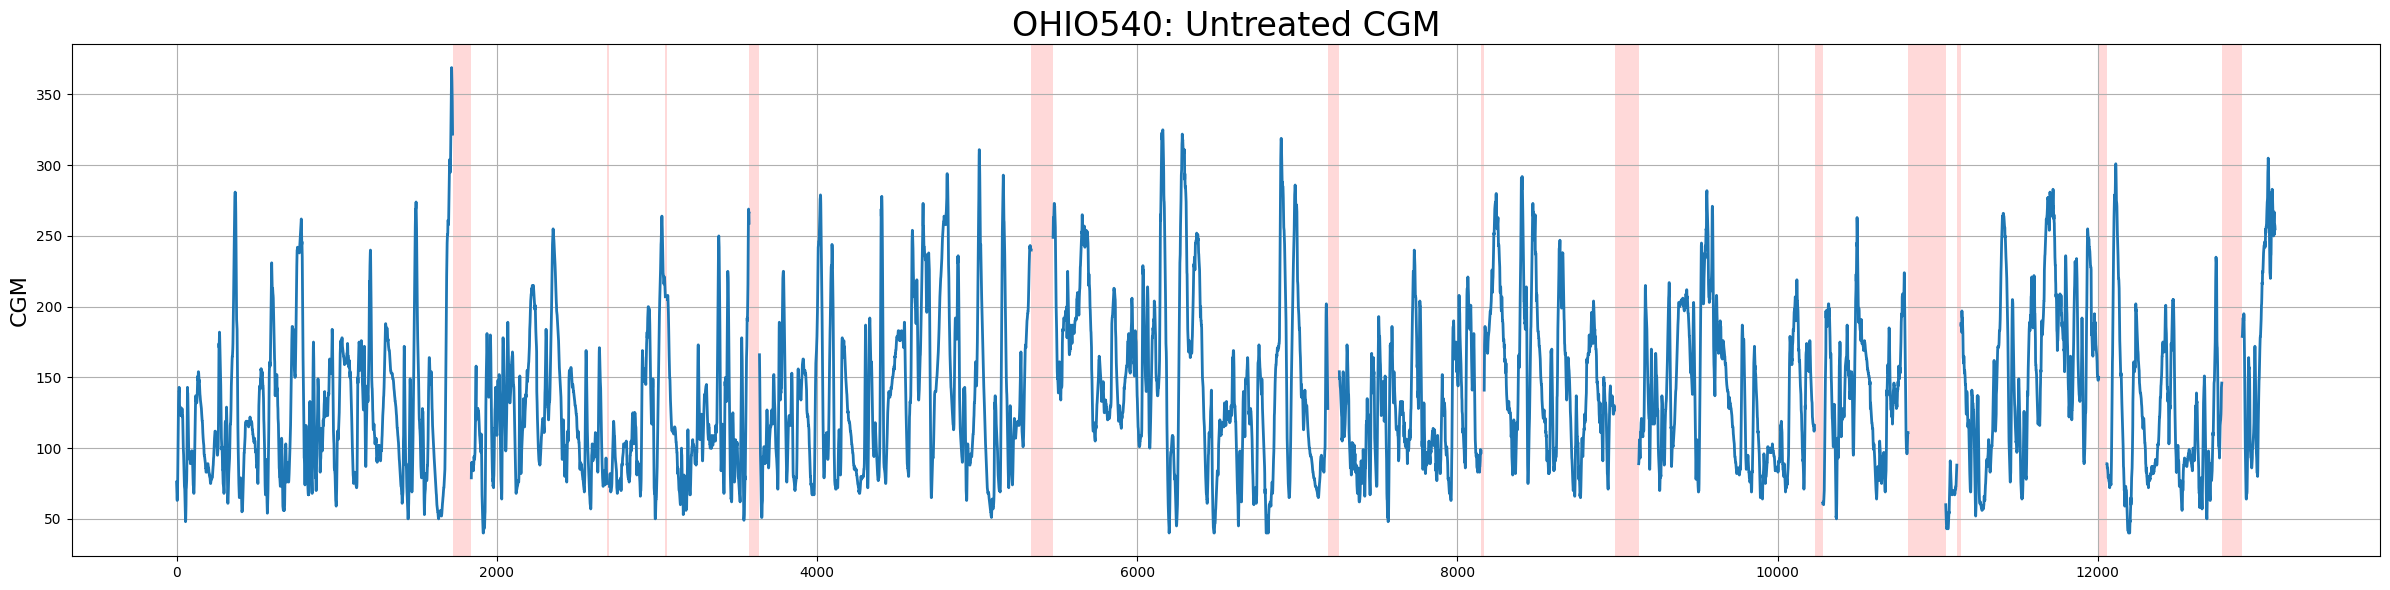

In [45]:
plt.figure(figsize=(24, 6))
plt.plot(L['CGM'], linewidth=2)
missing_indices = np.where(L['CGM'].isnull())[0]

for idx in missing_indices:
    plt.axvspan(idx-0.5, idx+0.5, facecolor='red', alpha=0.15)

title = 'OHIO540: Untreated CGM'
plt.title(title, fontsize=24)
plt.ylabel('CGM', fontsize=16)

plt.grid(True)
plt.tight_layout()

plt.savefig(f"../imgs/{title.replace(" ", "_")}.png")

In [46]:
def process_dataset(dataset):
    train_lst = []
    test_lst = []
    for key in dataset.keys():
        for data_type in ['train', 'test']:
            df = dataset[key][data_type]
            osize = df.shape[0]

            mask = df['CGM'].isna().rolling(25).sum().fillna(0) > 24
            df['group'] = (mask != mask.shift(1)).cumsum().astype(float)

            df_list = []

            for group in df['group'].unique():
                if df[df['group'] == group].shape[0] < 25:
                    df.loc[df['group'] == group, 'CGM'] = df.loc[df['group'] == group, 'CGM'].interpolate()
                else:
                    mask = df['group'] == group
                    split_index = df.loc[mask].shape[0] // 2
                    df1 = df.loc[mask].iloc[:split_index]
                    df2 = df.loc[mask].iloc[split_index:]
                    df1.dropna(subset=['CGM'], inplace=True)
                    df2.dropna(subset=['CGM'], inplace=True)

                    df1['Time'] = pd.to_datetime(df1['Time'], format="%d-%b-%Y %H:%M:%S")
                    df2['Time'] = pd.to_datetime(df2['Time'], format="%d-%b-%Y %H:%M:%S")

                    df1['diff'] = df1['Time'].diff()
                    df2['diff'] = df2['Time'].diff()

                    is_constant_df1 = (df1['diff'].nunique() == 1) and (df1['diff'].dropna().iloc[0] == Timedelta(minutes = 5))
                    is_constant_df2 = (df2['diff'].nunique() == 1) and (df2['diff'].dropna().iloc[0] == Timedelta(minutes = 5))
                    
                    df1.drop(columns=['diff', 'group'], inplace=True)
                    df2.drop(columns=['diff', 'group'], inplace=True)

                    if not df1.empty and is_constant_df1 and len(df1) > 6:
                        df_list.append(df1)

                    if not df2.empty and is_constant_df2 and len(df2) > 6:
                        df_list.append(df2)
            
            for i, df in enumerate(df_list):
                if df.isnull().values.any():
                    print(f"DataFrame at index {i} contains null values.")
            print(f"Original size: {osize}, New size: {sum([df.shape[0] for df in df_list])}")
            
            if data_type == 'train':
                train_lst.extend(df_list)
            else:
                test_lst.extend(df_list)
    return train_lst, test_lst

In [47]:
def append_ds(dataset):
    train_lst = []
    test_lst = []
    for key in dataset.keys():
        for data_type in ['train', 'test']:
            df = dataset[key][data_type]
            osize = df.shape[0]

            mask = df['CGM'].isna().rolling(25).sum().fillna(0) > 24
            df['group'] = (mask != mask.shift(1)).cumsum().astype(float)

            df_list = []

            for group in df['group'].unique():
                if df[df['group'] == group].shape[0] < 25:
                    df.loc[df['group'] == group, 'CGM'] = df.loc[df['group'] == group, 'CGM'].interpolate()
                else:
                    mask = df['group'] == group
                    split_index = df.loc[mask].shape[0] // 2
                    df1 = df.loc[mask].iloc[:split_index]
                    df2 = df.loc[mask].iloc[split_index:]
                    df1.dropna(subset=['CGM'], inplace=True)
                    df2.dropna(subset=['CGM'], inplace=True)

                    df1['Time'] = pd.to_datetime(df1['Time'], format="%d-%b-%Y %H:%M:%S")
                    df2['Time'] = pd.to_datetime(df2['Time'], format="%d-%b-%Y %H:%M:%S")

                    df1['diff'] = df1['Time'].diff()
                    df2['diff'] = df2['Time'].diff()

                    is_constant_df1 = (df1['diff'].nunique() == 1) and (df1['diff'].dropna().iloc[0] == Timedelta(minutes = 5))
                    is_constant_df2 = (df2['diff'].nunique() == 1) and (df2['diff'].dropna().iloc[0] == Timedelta(minutes = 5))
                    
                    df1.drop(columns=['diff', 'group'], inplace=True)
                    df2.drop(columns=['diff', 'group'], inplace=True)

                    if not df1.empty and is_constant_df1 and len(df1) > 6:
                        df_list.append(df1)

                    if not df2.empty and is_constant_df2 and len(df2) > 6:
                        df_list.append(df2)
            
            for i, df in enumerate(df_list):
                if df.isnull().values.any():
                    print(f"DataFrame at index {i} contains null values.")
            print(f"Original size: {osize}, New size: {sum([df.shape[0] for df in df_list])}")
            
            if data_type == 'train':
                train_lst.append(df_list)
            else:
                test_lst.append(df_list)
    return train_lst, test_lst

In [48]:
tr, te =  append_ds(dataset)

Original size: 13109, New size: 9499
Original size: 3066, New size: 748
Original size: 12672, New size: 10488
Original size: 3136, New size: 1693
Original size: 11098, New size: 6124
Original size: 3950, New size: 226
Original size: 12081, New size: 5113
Original size: 2877, New size: 328
Original size: 13097, New size: 12165
Original size: 2692, New size: 1711
Original size: 13536, New size: 8151
Original size: 2870, New size: 935
Original size: 11611, New size: 9032
Original size: 2879, New size: 0
Original size: 13103, New size: 7254
Original size: 2719, New size: 0
Original size: 13247, New size: 8125
Original size: 2995, New size: 0
Original size: 13105, New size: 10977
Original size: 2881, New size: 2791
Original size: 12756, New size: 10929
Original size: 2847, New size: 2009


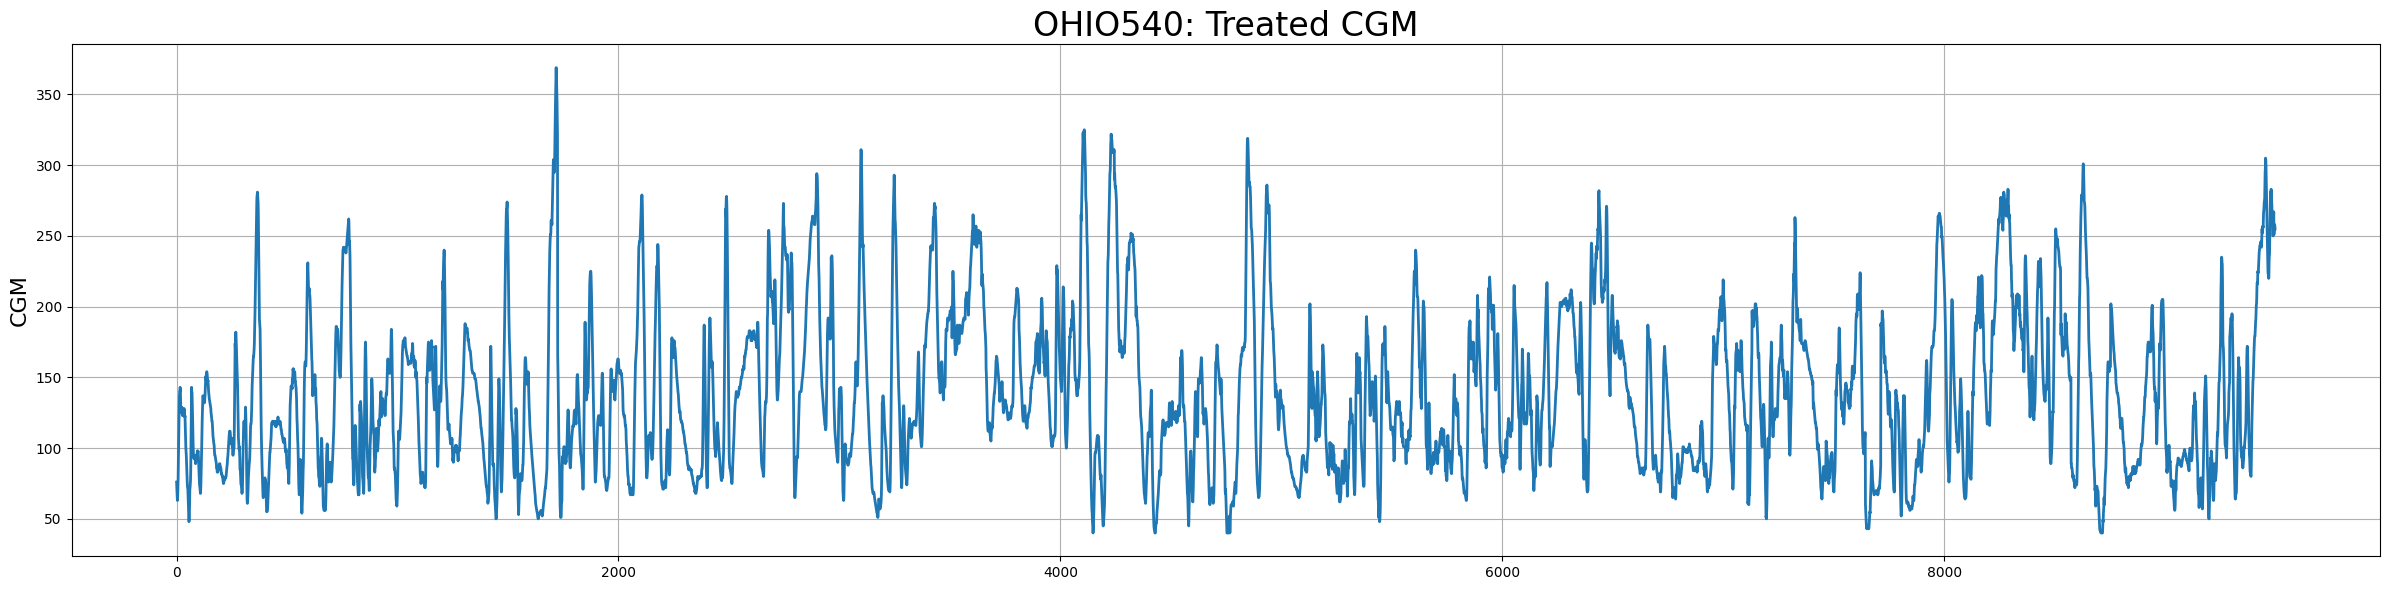

In [49]:
k = pd.concat(tr[0])['CGM'].reset_index(drop=True)

plt.figure(figsize=(24, 6))
plt.plot(k, linewidth=2)

title = 'OHIO540: Treated CGM'
plt.title(title, fontsize=24)
plt.ylabel('CGM', fontsize=16)

plt.grid(True)
plt.tight_layout()

plt.savefig(f"../imgs/{title.replace(" ", "_")}.png")

plt.show()

In [74]:
l = []
for i, df in enumerate(tr[0]):
    l.append(get_train_dataset(df.copy()).iloc[24:])

In [50]:
train_lst, test_lst = process_dataset(dataset)

Original size: 13109, New size: 9499
Original size: 3066, New size: 748
Original size: 12672, New size: 10488
Original size: 3136, New size: 1693
Original size: 11098, New size: 6124
Original size: 3950, New size: 226
Original size: 12081, New size: 5113
Original size: 2877, New size: 328
Original size: 13097, New size: 12165
Original size: 2692, New size: 1711
Original size: 13536, New size: 8151
Original size: 2870, New size: 935
Original size: 11611, New size: 9032
Original size: 2879, New size: 0
Original size: 13103, New size: 7254
Original size: 2719, New size: 0
Original size: 13247, New size: 8125
Original size: 2995, New size: 0
Original size: 13105, New size: 10977
Original size: 2881, New size: 2791
Original size: 12756, New size: 10929
Original size: 2847, New size: 2009


In [51]:
train_df = pd.concat(train_lst, ignore_index=True)

In [52]:
for i, df in enumerate(train_lst):
    train_lst[i] = get_train_dataset(df.copy()).iloc[24:]

In [53]:
for i, df in enumerate(test_lst):
    test_lst[i] = get_any_dataset(df.copy(), train_df).iloc[24:]

In [54]:
train_data = pd.concat(train_lst, ignore_index=True)
test_data = pd.concat(test_lst, ignore_index=True)

In [55]:
train_data.shape, test_data.shape

((91623, 21), (9697, 21))

In [56]:
train_data.head()

,CGM,month,day,hour,minute,weekday,year,wCGM(1),wCGM(2),wCGM(3),...,wCGM(5),wCGM(6),cgm_velo,change,upper_band,lower_band,extreme_CGM_80,extreme_CGM_85,extreme_CGM_90,extreme_CGM_95
0,129.0,5,19,13,35,2,2027,129.0,128.333333,127.666667,...,126.866667,129.476190,0.003333,1.0,198.092207,17.324460,0,0,0,0
1,127.0,5,19,13,40,2,2027,129.0,129.000000,128.500000,...,127.933333,127.095238,0.000000,0.0,198.840303,20.993031,0,0,0,0
2,124.0,5,19,13,45,2,2027,127.0,128.333333,128.666667,...,127.933333,127.952381,-0.006667,-2.0,198.288080,26.128586,0,0,0,0
3,123.0,5,19,13,50,2,2027,124.0,126.000000,127.500000,...,128.066667,127.761905,-0.010000,-3.0,196.078435,33.004898,0,0,0,0
4,124.0,5,19,13,55,2,2027,123.0,123.666667,125.333333,...,127.533333,127.666667,-0.003333,-1.0,192.197842,41.718824,0,0,0,0


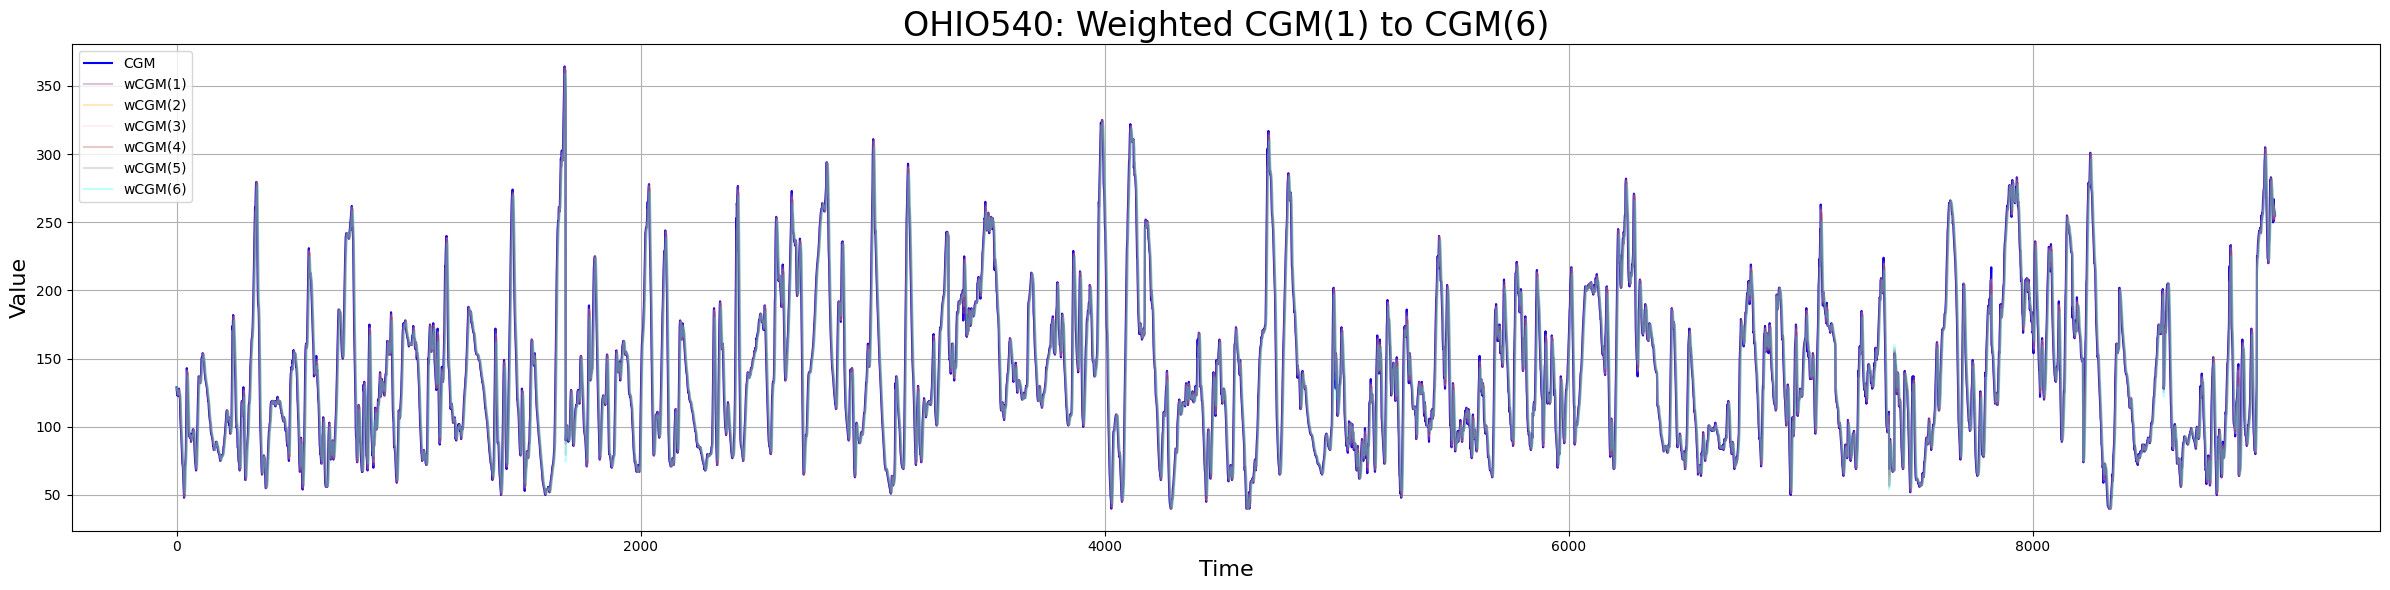

In [88]:
df = pd.concat(l).reset_index(drop=True)

plt.figure(figsize=(24, 6))

plt.plot(df['CGM'], color='blue', label='CGM')

colors = ['purple', 'orange', 'pink', 'brown', 'grey', 'cyan']
for i in range(1, 7):
    plt.plot(df[f'wCGM({i})'], color=colors[i-1], label=f'wCGM({i})', alpha=0.25)

plt.title('OHIO540: Weighted CGM(1) to CGM(6)', fontsize=24)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Value', fontsize=16)

plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

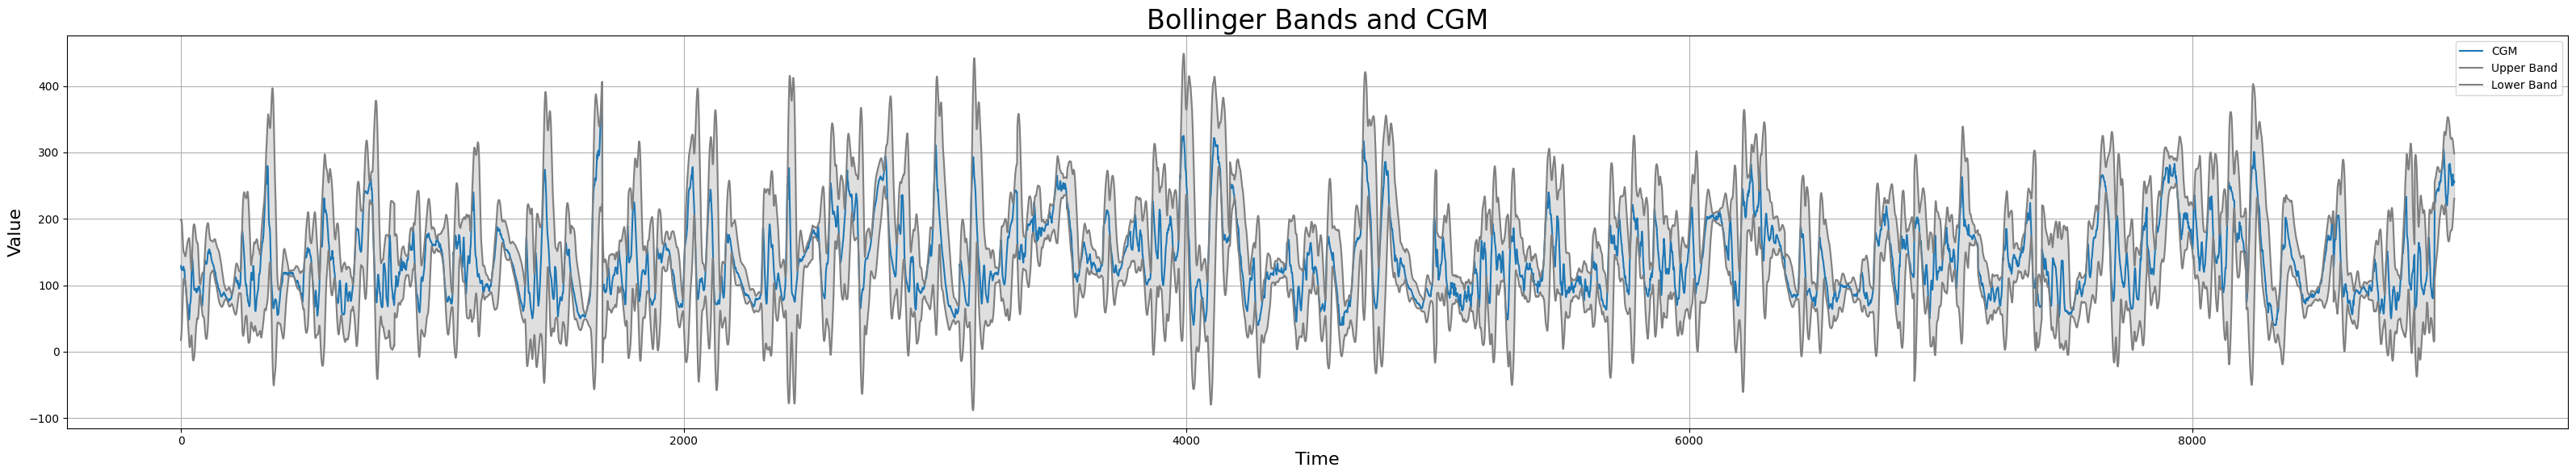

In [85]:
plt.figure(figsize=(32, 6))

# Plot CGM values
plt.plot(df['CGM'], label='CGM')

# Plot Bollinger Bands
plt.plot(df['upper_band'], color='grey', label='Upper Band')
plt.fill_between(df.index, df['upper_band'], df['lower_band'], color='grey', alpha=0.25)
plt.plot(df['lower_band'], color='grey', label='Lower Band')

plt.title('OHIO540: Bollinger Bands with CGM', fontsize=24)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Value', fontsize=16)

plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

C:\Users\Tawan\AppData\Local\Temp\ipykernel_25028\498449135.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r')


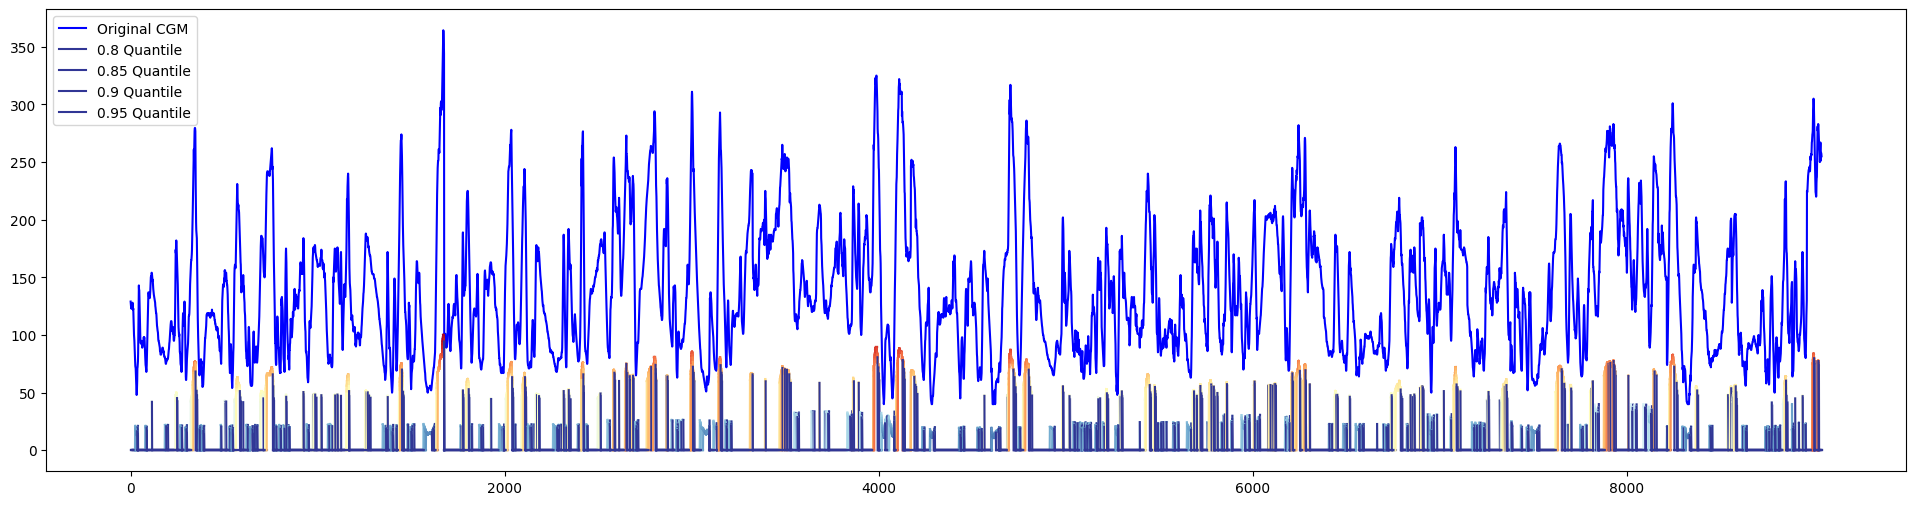

In [100]:
import matplotlib.cm as cm

plt.figure(figsize=(24, 6))
plt.plot(df['CGM'], label='Original CGM', color='blue')

quantiles = [0.80, 0.85, 0.90, 0.95]
for quantile in quantiles:
    extreme_CGM = df[f'extreme_CGM_{int(quantile * 100)}'] * df['CGM']
    normalized_CGM = ((extreme_CGM - extreme_CGM.min()) / (extreme_CGM.max() - extreme_CGM.min())) * 100

    # Create a colormap
    cmap = cm.get_cmap('RdYlBu_r')

    # Map the normalized CGM values to colors
    colors = cmap(normalized_CGM / 100.0)

    # Plot with gradient
    for i in range(1, len(normalized_CGM)):
        plt.plot([i-1, i], [normalized_CGM.iloc[i-1], normalized_CGM.iloc[i]], color=colors[i], linestyle='-', label=f'{quantile} Quantile' if i == 1 else "")

plt.legend()
plt.show()

The tuning data will be merged with the training data and be fitted into the pipeline to be used for the validation data

In [59]:
trainX, trainY = train_data.drop(["CGM"], axis = 1), train_data["CGM"]
trainX.shape, trainY.shape

((91623, 20), (91623,))

In [60]:
testX, testY = test_data.drop(["CGM"], axis = 1), test_data["CGM"]
testX.shape, testY.shape

((9697, 20), (9697,))

In [61]:
model = HybridModel(use_navigator=True)
model.fit(trainX, trainY, testX, testY, eval = True, tune = False)

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.0126173
Test accuracy: 99.74 %
Base fitted with columns: Index(['month', 'day', 'hour', 'minute', 'weekday', 'year', 'wCGM(1)',
       'wCGM(2)', 'wCGM(3)', 'wCGM(4)', 'wCGM(5)', 'wCGM(6)', 'cgm_velo',
       'change', 'upper_band', 'lower_band', 'extreme_CGM_80',
       'extreme_CGM_85', 'extreme_CGM_90', 'extreme_CGM_95', 'direction'],
      dtype='object')
Base: (14.74135703295785, 3.8394474905847913, 0.07190868397727075)
Base + Residuals: (14.772089046127435, 3.8434475469462877, 0.07152750684858053) Change: 3.9436306151438743%


In [62]:
def plot_forecast(X, y, model, n_steps = 12, lookback = 0, use_confi = True, navigator_weight = 1, show_median = False, plot = True):
    if len(X.shape) == 1 or X.shape[1] == 0:
        raise ValueError("Input data must be 2 dimensional and non empty.")
    
    if len(X) != len(y):
        raise ValueError("Input data and output data must have the same length.")
    
    if X.shape[0] > n_steps:
        result = model.forecast(X.iloc[:-n_steps], n_steps = n_steps, return_X = False, use_confi = use_confi, navigator_weight = navigator_weight * 100)
        forecast = result["forecasts"]
        actual = y.iloc[-n_steps - lookback:].reset_index(drop = True)
    else:
        result = model.forecast(X, n_steps = n_steps, return_X = False, use_confi = use_confi, navigator_weight = navigator_weight)
        forecast = result["forecasts"]
        actual = y.iloc[-n_steps - lookback:].reset_index(drop = True)
    
    if plot:
        plt.figure(figsize = (15, 5))
        plt.title('Forecast vs Actual', fontsize=20)
        plt.xlabel('Iterations', fontsize=15)
        plt.ylabel('Glucose', fontsize=15)
        plt.grid(True)
        
        if use_confi:
            confi_int = result["confi_forecasts"]
            if show_median:
                plt.plot(np.arange(lookback, len(forecast) + lookback), confi_int['Median'], label = "Median", color = "black", linestyle='--', linewidth=2)
            plt.fill_between(np.arange(lookback, len(forecast) + lookback), confi_int["Lower"], confi_int["Upper"], color = "black", alpha = 0.15)

        plt.plot(actual, label = "Actual", color = "blue", linewidth=2)
        plt.plot(np.arange(lookback, len(forecast) + lookback), forecast, label = "Forecast", color = "green", linestyle='-', linewidth=2)
        
        plt.legend(fontsize=12)
        plt.show()
    
    rmse = np.sqrt(mean_squared_error(actual.iloc[lookback:], forecast))
    return rmse

In [63]:
def find_best_navigator_weight(X, y, model, n_steps = 12, n_iter = 5):
    best_rmse = float('inf')
    best_navigator_weight = None
    for navigator_weight in range(-64, 64):
        rmses = []
        for i in range(n_iter):
            start_idx = np.random.randint(0, len(X) - n_steps)
            X_sample = X[start_idx : start_idx + n_steps]
            y_sample = y[start_idx : start_idx + n_steps]
            rmse = plot_forecast(X_sample, y_sample, model, n_steps = n_steps, navigator_weight = navigator_weight, use_confi = False, plot = False)
            rmses.append(rmse)
        mean_rmse = np.mean(rmses)
        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_navigator_weight = navigator_weight
    return best_navigator_weight, best_rmse

In [64]:
def evaluate(X, y, model, n_steps = 12, navigator_weight = 1, n_iter = 10, lookback = 12, use_confi = False, plot = False, indices = []):
    rmses = []
    times = []

    indices = []

    print("Evaluating with weights =", navigator_weight)
    for i in tqdm(range(n_iter)):

        start_idx = np.random.randint(0, len(X) - n_steps - lookback)
        end_idx = start_idx + lookback + n_steps
            
        X_sample = X[start_idx: end_idx]
        y_sample = y[start_idx: end_idx]
        start_time = time.time()
        rmse = plot_forecast(X_sample, y_sample, model, lookback = lookback, n_steps = n_steps, navigator_weight = navigator_weight, use_confi = use_confi, plot = plot)
        end_time = time.time()
        rmses.append(rmse)
        times.append(end_time - start_time)
        indices.append((start_idx, end_idx))
    
    print("Avg Forecast Time:", sum(times) / len(times), "seconds")

    return np.mean(rmses), max(rmses), min(rmses), indices

In [65]:
steps = [3, 6, 9, 12, 15, 18, 21, 24]
means, mxs, mns = [], [], []
for step in steps:
    mean, mx, mn, _ = evaluate(testX, testY, model, n_steps = step, navigator_weight = 1, n_iter = 100, plot = False)
    means.append(mean)
    mxs.append(mx)
    mns.append(mn)
    print(f"For step size {step}, Mean RMSE: {mean}, Max RMSE: {mx}, Min RMSE: {mn}")

Evaluating with weights = 1


 62%|██████▏   | 62/100 [00:06<00:04,  9.23it/s]


KeyboardInterrupt: 

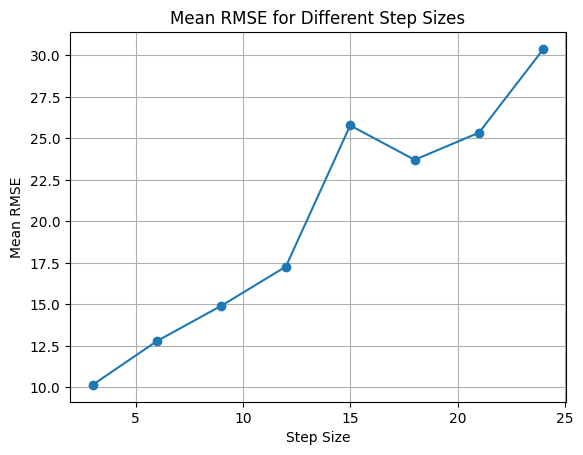

In [ ]:
plt.plot(steps, means, marker='o')
plt.xlabel('Step Size')
plt.ylabel('Mean RMSE')
plt.title('Mean RMSE for Different Step Sizes')
plt.grid(True)
plt.show()